In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/150524_gatr/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/150524_gatr/showers_df_evaluation/0_0_None_pandora.pt"
sd_pandora, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

In [3]:
sd_hgb

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,true_pos
0,6.374537,6.667327,5.539594,5.379109,-2212.0,1.0,5.539594,0.0,0.0,0.0,"[-0.09912260621786118, -0.9810044169425964, -0..."
1,1.670063,0.915923,0.915923,0.915923,2212.0,1.0,0.915923,0.0,0.0,0.0,"[-0.020040249451994896, -0.8865023851394653, 0..."
2,1.409421,0.529537,NaN,NaN,2112.0,NaN,NaN,0.0,0.0,0.0,"[0.326257586479187, -0.85720294713974, 0.39844..."
3,6.391420,6.403108,6.381646,6.375263,11.0,1.0,6.381646,0.0,0.0,0.0,"[0.15251800417900085, -0.9797354340553284, 0.1..."
4,2.963686,0.996842,0.701617,0.701617,130.0,1.0,0.701617,0.0,0.0,0.0,"[-0.41901692748069763, -0.9079718589782715, -0..."
...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,0.118225,NaN,NaN,1.0,0.118225,268.0,537.0,NaN,"[nan, nan, nan]"
76,NaN,NaN,0.225183,NaN,NaN,1.0,0.225183,268.0,537.0,NaN,"[nan, nan, nan]"
77,NaN,NaN,0.947339,NaN,NaN,1.0,0.947339,268.0,537.0,NaN,"[nan, nan, nan]"
78,NaN,NaN,0.904618,NaN,NaN,1.0,0.904618,268.0,537.0,NaN,"[nan, nan, nan]"


In [4]:
# reduced_p = sd_pandora[sd_pandora.pid==130]
# reduced_p[np.isnan(reduced_p.pred_showers_E)]

In [4]:
def calculate_eff(sd, log_scale=False):
    if log_scale:
        bins = np.exp(np.arange(np.log(0.1), np.log(80), 0.3))
    else:
        bins = np.arange(0, 51, 5)
    eff = []
    energy_eff = []
    errors = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.reco_showers_E.values <= bin_i1
        mask_below = sd.reco_showers_E.values > bin_i
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            eff.append(
                (total_showers - number_of_non_reconstructed_showers) / total_showers
            )
            energy_eff.append((bin_i1 + bin_i) / 2)
            n_total = total_showers
            n_r = total_showers - number_of_non_reconstructed_showers
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            print(total_showers, n_r, error)
            error = np.sqrt(error)
            errors.append(error)
    return eff, energy_eff, errors

def create_eff_dic(photons_dic, matched_, id, var_i):
    pids = np.abs(matched_["pid"].values)
    mask_id = pids == id
    df_id = matched_[mask_id]

    eff, energy_eff, errors = calculate_eff(df_id, False)
    photons_dic["eff_" + str(var_i)] = eff
    photons_dic["energy_eff_" + str(var_i)] = energy_eff
    photons_dic["errors" + str(var_i)] = errors
    return photons_dic

def create_eff_dic_pandora(matched_pandora, id):
    pids_pandora = np.abs(matched_pandora["pid"].values)
    mask_id = pids_pandora == id
    df_id_pandora = matched_pandora[mask_id]
    eff_p, energy_eff_p, errors = calculate_eff(df_id_pandora, False)
    photons_dic = {}
    photons_dic["eff_p"] = eff_p
    photons_dic["energy_eff_p"] = energy_eff_p
    photons_dic["errors_p"] = errors
    return photons_dic

In [5]:
# from src.utils.inference.per_particle_metrics import create_eff_dic_pandora, create_eff_dic
photons_dic = create_eff_dic_pandora(sd_pandora, 22)
electrons_dic = create_eff_dic_pandora(sd_pandora, 11)
pions_dic = create_eff_dic_pandora(sd_pandora, 211)
kaons_dic = create_eff_dic_pandora(sd_pandora, 130)

var_i = "0"
photons_dic = create_eff_dic(photons_dic, sd_hgb, 22, var_i=var_i)
electrons_dic = create_eff_dic(electrons_dic, sd_hgb, 11, var_i=var_i)
pions_dic = create_eff_dic(pions_dic, sd_hgb, 211, var_i=var_i)
kaons_dic = create_eff_dic(kaons_dic, sd_hgb, 130, var_i=var_i)


5211 3148 0.00018596269414303932
727 713 0.002672075895741601
400 395 0.004906640625000001
281 280 0.00707948935194414
175 175 0.011428571428571427
146 146 0.0136986301369863
149 149 0.013422818791946307
100 100 0.020000000000000004
97 97 0.02061855670103092
93 93 0.021505376344086027
2559 2391 0.0007062751359167972
650 642 0.003020351388256714
420 419 0.004744911456646151
257 253 0.007601360456772071
215 213 0.009172928169846679
147 145 0.013329039330110311
132 132 0.015151515151515154
114 114 0.017543859649122803
94 94 0.021276595744680854
61 61 0.03278688524590164
1662 1560 0.0010948561849705653
573 550 0.0032830581860550994
304 298 0.006385457291514799
228 222 0.008428706808572679
181 179 0.010867253729968981
149 148 0.01328799204582658
111 110 0.017775262479426103
107 103 0.017656523077149128
86 86 0.023255813953488372
56 56 0.035714285714285705
1954 1172 0.0004910694389283396
566 494 0.002887909109243176
329 272 0.004590454448307109
216 198 0.008134002057613169
193 175 0.00895805

(0.55, 1.05)

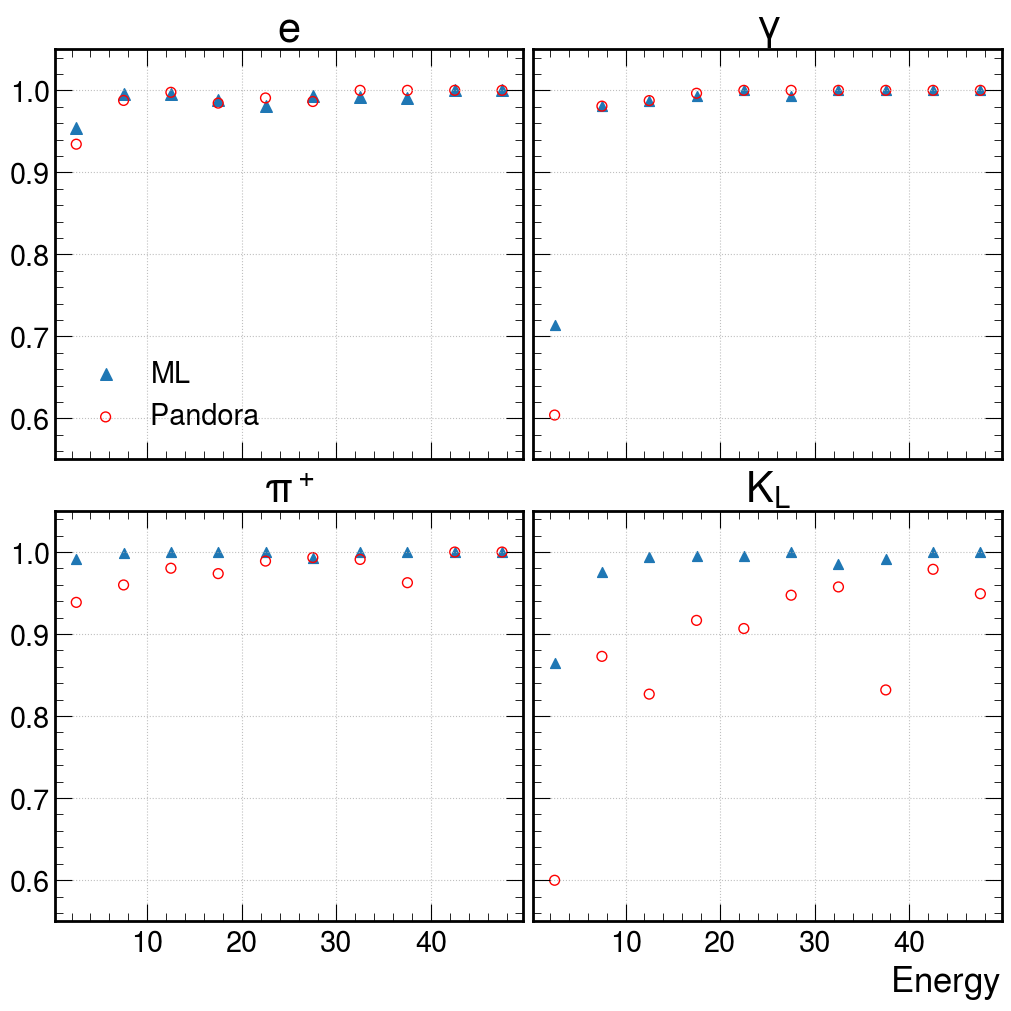

In [6]:
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
markers = ["^", "*", "x", "d", ".", "s"]
i =0
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained")
axs[0, 0].scatter(
            electrons_dic["energy_eff_" + str(i)],
            electrons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=70,
        )
# axs[0, 0].errorbar(electrons_dic["energy_eff_" + str(i)], electrons_dic["eff_" + str(i)] ,yerr= electrons_dic["errors" + str(i)], linestyle='none')

axs[0, 0].scatter(
    electrons_dic["energy_eff_p"],
    electrons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[0, 0].errorbar(electrons_dic["energy_eff_p"], electrons_dic["eff_p"] ,yerr= electrons_dic["errors_p"], linestyle='none')

axs[0, 0].set_title("$e$")
axs[0,0].set_ylim([0.55,1.05])
axs[0,0].grid()
axs[0,0].legend()
axs[0, 1].scatter(
            photons_dic["energy_eff_" + str(i)],
            photons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
# axs[0, 1].errorbar(photons_dic["energy_eff_" + str(i)], photons_dic["eff_" + str(i)] ,yerr= photons_dic["errors" + str(i)], linestyle='none')

axs[0, 1].scatter(
    photons_dic["energy_eff_p"],
    photons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[0, 1].errorbar(photons_dic["energy_eff_p"], photons_dic["eff_p"] ,yerr= photons_dic["errors_p"], linestyle='none')

axs[0, 1].set_title("$\\gamma$")
axs[0, 1].set_ylim([0.55,1.05])
axs[0, 1].grid()
axs[1, 0].scatter(
            pions_dic["energy_eff_" + str(i)],
            pions_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
axs[1, 0].scatter(
    pions_dic["energy_eff_p"],
    pions_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
axs[1, 0].set_title("$\\pi^+$")
axs[1, 0].set_ylim([0.55,1.05])
axs[1, 0].grid()
axs[1, 1].scatter(
            kaons_dic["energy_eff_" + str(i)],
            kaons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
# axs[1, 1].errorbar(kaons_dic["energy_eff_" + str(i)], kaons_dic["eff_" + str(i)] ,yerr= kaons_dic["errors" + str(i)], linestyle='none')

axs[1, 1].scatter(
    kaons_dic["energy_eff_p"],
    kaons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[1, 1].errorbar(kaons_dic["energy_eff_p"], kaons_dic["eff_p"] ,yerr= kaons_dic["errors_p"], linestyle='none')

axs[1, 1].set_title("$K_L$")
axs[1, 1].set_xlabel("$Energy$")
axs[1, 1].grid()
axs[1, 1].set_ylim([0.55,1.05])